<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running cellpose3 in colab with a GPU

<font size = 4>Cellpose3 now allows you to restore and segment noisy/blurry/low res images!

For more details on Cellpose3 check out the [paper](https://www.biorxiv.org/content/10.1101/2024.02.10.579780v1).

Mount your google drive to access all your image files. This also ensures that the segmentations are saved to your google drive.

## Installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [2]:
!pip install "opencv-python"
!pip install cellpose

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.9/225.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [2]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Wed Apr 16 09:35:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8       

## Images

Load in your own data or use ours (below)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


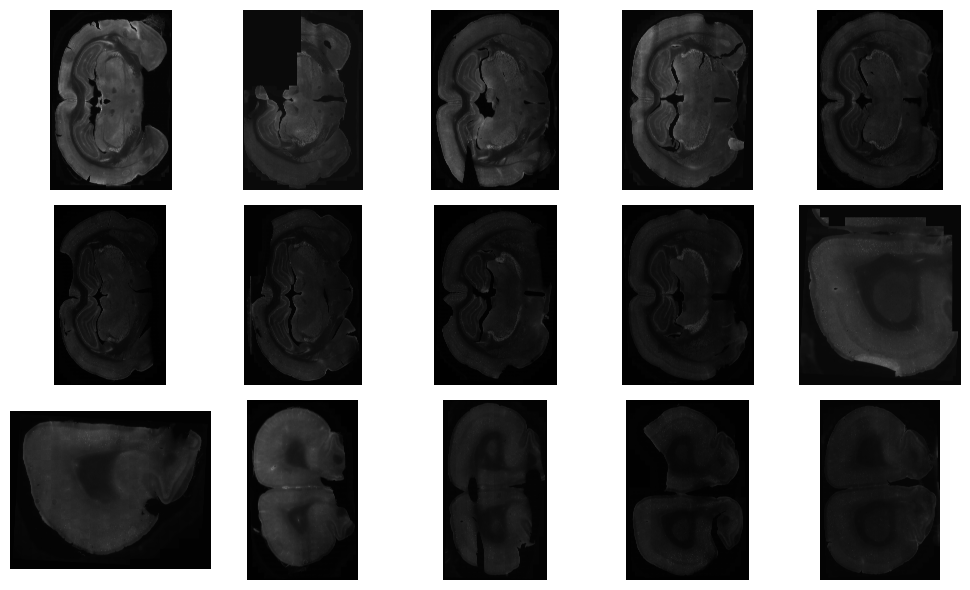

In [22]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from glob import glob
from cellpose.io import imread

# For inline plotting
%matplotlib inline
mpl.rcParams['figure.dpi'] = 100  # lower resolution for faster rendering

# Path to your image folder
image_dir = "/content/drive/Othercomputers/My laptop/Cellpose"

# Load all .tif and .tiff files
image_files = sorted(glob(os.path.join(image_dir, "*.tif")) +
                     glob(os.path.join(image_dir, "*.tiff")))

# Read the images
imgs = [imread(f) for f in image_files]

# Show all images (adjust grid size dynamically)
n_images = len(imgs)
cols = 5
rows = (n_images + cols - 1) // cols

plt.figure(figsize=(cols * 2, rows * 2))  # Adjust size as needed
for i, img in enumerate(imgs):
    img = img.squeeze()
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [2]:
# Create a 4GB swap file using dd (you can increase to 8G or 10G if needed and if there's disk space)
!dd if=/dev/zero of=/swapfile bs=1M count=4096

# Set correct permissions
!chmod 600 /swapfile

# Make it a swap area
!mkswap /swapfile

# Enable the swap
!swapon /swapfile

# Verify swap is on
!swapon --show


4096+0 records in
4096+0 records out
4294967296 bytes (4.3 GB, 4.0 GiB) copied, 25.9529 s, 165 MB/s
Setting up swapspace version 1, size = 4 GiB (4294963200 bytes)
no label, UUID=81f22a7b-594b-4218-a7fe-16431bc1f336
swapon: /swapfile: swapon failed: Invalid argument


## Run segmentation and plot results

In [1]:
import os
import glob
import shutil
from cellpose import models, io
from cellpose.io import imread
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from google.colab import drive

# Set up logging
io.logger_setup()

# Reuse the image directory from the first code block
image_dir = "/content/drive/Othercomputers/My laptop/Cellpose"

# Find all .tif and .tiff files
files_list = sorted(glob.glob(os.path.join(image_dir, '*.tif')) + glob.glob(os.path.join(image_dir, '*.tiff')))

# Use grayscale channels (assuming one channel per image)
channels = [[0, 0]] * len(files_list)  # [0, 0] for grayscale

# Define the path to your pretrained model on Google Drive
model_path = '/content/drive/Othercomputers/My laptop/Cellpose/CP_all_DMaps_v2'

# Load your custom pretrained model
model = models.CellposeModel(pretrained_model=model_path, gpu=True)

# Create a list to store the masks and flows for display
masks_list = []

# Create a figure for live plotting
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Loop over each image file and process them
for chan, filename in zip(channels, files_list):
    try:
        print(f"Processing: {filename}")
        img = imread(filename)

        # Run inference with your pretrained model
        masks, flows, styles = model.eval(img, diameter=None, channels=chan)

        # Save the processed masks (for visualization in the next step)
        masks_list.append(masks)

        # Save Cellpose GUI-compatible outputs
        io.masks_flows_to_seg(img, masks, flows, filename, channels=chan, diams=None)

        # Save ImageJ-compatible ROIs
        base_name = os.path.splitext(os.path.basename(filename))[0]
        roi_path = os.path.join(image_dir, f"{base_name}_rois")
        io.save_rois(masks, roi_path)

        # Live plot: show original image and mask side by side
        plt.clf()  # Clear the previous figure
        original_img = imread(filename)

        # Plot the original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_img.squeeze(), cmap="gray")
        plt.title(f"Original {os.path.basename(filename)}")
        plt.axis('off')

        # Plot the mask
        plt.subplot(1, 2, 2)
        plt.imshow(masks.squeeze(), cmap="gray")
        plt.title(f"Mask {os.path.basename(filename)}")
        plt.axis('off')

        plt.draw()  # Draw the updated figure
        plt.pause(1)  # Pause to allow the plot to update (1 second)

    except Exception as e:
        print(f"Error processing {filename}: {e}")

plt.show()  # Finalize the plotting after the loop completes

<Figure size 1200x600 with 0 Axes>